<a href="https://colab.research.google.com/github/prasann25/colab/blob/main/07_milestone_proj_1_food_vision_big.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MileStone Project 1 : Food Vision Big

See the annotated version of this notebook on GitHub : https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

## Check GPU

Google Colab offers free GPUs(thank you Google), however, not all of them are compatible with mixed precision training. 
We need Nvidia V100, T4 or A100 to get the benefits of mixed precision training https://www.tensorflow.org/guide/mixed_precision

Google Colab offers :
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training, we need access to a Tesla T4( from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here : https://developer.nvidia.com/cuda-gpus).

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3b3e7e3e-ba54-9f99-0cf4-c86b3612a5b0)


## Get helper functions
 In past modules, we've created a bunch of helper functions to do small tasks required for notebooks.

 Rather than rewrite all of these, we can import a script and load them in from there.
 The script we've got available can be found on GitHub :
 https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-30 17:45:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-30 17:45:24 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide :https://www.tensorflow.org/datasets/catalog/overview#all_datasets

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds


In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # got all available datasets in TFDS
print("food101" in datasets_list) # is our taget dataset in the list of TFDS datasets

True


In [9]:
#Load in the data(takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"], 
                                             shuffle_files=True,
                                             as_supervised = True, # data gets returned in tuple format (data, label)
                                             with_info=True)


## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find :
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [10]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [11]:
# Get the class names
class_names = ds_info.features["label"].names

class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [37]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format(image_tensor, label)


In [36]:
# What does one sample of our training data look like ?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [38]:
# Output info about our training sample
for image, label in train_one_sample :
  print(f"""
  Image shape : {image.shape}
  Image datatype : {image.dtype}
  Target class from Food 101 (tensor form) : {label}
  Class name (str form) : {class_names[label.numpy()]}
  """)


  Image shape : (512, 512, 3)
  Image datatype : <dtype: 'uint8'>
  Target class from Food 101 (tensor form) : 43
  Class name (str form) : fried_calamari
  


In [25]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 40,  51,  53],
        [ 42,  53,  55],
        [ 39,  50,  54],
        ...,
        [254, 255, 247],
        [254, 255, 247],
        [254, 255, 247]],

       [[ 38,  49,  51],
        [ 41,  52,  54],
        [ 39,  50,  54],
        ...,
        [254, 255, 247],
        [254, 255, 247],
        [254, 255, 247]],

       [[ 42,  53,  57],
        [ 45,  56,  60],
        [ 42,  53,  57],
        ...,
        [254, 255, 247],
        [254, 255, 247],
        [254, 255, 247]],

       ...,

       [[116, 102,  53],
        [105,  91,  42],
        [ 89,  75,  30],
        ...,
        [ 43,  39,  28],
        [ 44,  40,  29],
        [ 41,  37,  26]],

       [[110,  96,  47],
        [101,  87,  38],
        [ 87,  73,  28],
        ...,
        [ 41,  37,  26],
        [ 41,  37,  26],
        [ 40,  36,  25]],

       [[100,  86,  37],
        [ 95,  81,  32],
        [ 88,  74,  29],
        ...,
        [ 44,  40,  2

In [27]:
# What are the min and max values of our image tensor?
import tensorflow as tf

tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from Tensorflow Datasets

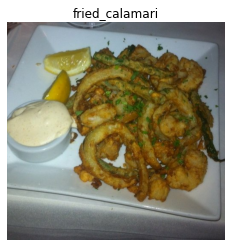

In [39]:
# Plot an image tensor
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);
  

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).
However, not all data(including data from TensorFlow Datasets) come like this.
So in order to get it ready for a neural network, you'll often have to write preprocessing fuctions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled ( the pixel values are between 0 & 255)

What we know models like :
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow like all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better.

With these points in mind, we've got a few things we can tackle with a preprocessing function. 
Since we're going to be using an EfficientNetBX pretrained model from `tf.keras.applications`, we don't need to rescale our data (these architectures have rescaling built-in).

This means our function needs to :
1. Reshape our images to all of the same size.
2. Convert the dtype of our image tensors `uint8` to `float32`

In [48]:
# Make a function  for preprocessing images
def preprocess_img(image, label, img_shape=224) :
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes 
  image to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  # image = image/255. # scale image values (not requrired with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label # return (float32 image, label) tuple

In [49]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}" )

Image before preprocessing:
 [[[71 60 56]
  [70 59 55]
  [70 59 55]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]

 [[62 51 47]
  [64 53 49]
  [66 55 51]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 65.811226  54.811222  50.811222]
  [ 73.331635  62.331635  58.331635]
  [104.015305  89.80102   86.80102 ]
  ...
  [ 61.85712   59.071384  65.64286 ]
  [ 65.        60.        67.      ]
  [ 64.64282   59.642822  66.64282 ]]

 [[ 67.28571   56.285717  52.285717]
  [ 66.47449   55.47449   51.47449 ]
  [ 67.73979   53.525505  50.525505]
  ...
  [ 64.14284   61.3571    67.92857 ]
  [ 65.93368   60.933674  67.93368 ]
  [ 64.285645  59.285645  66.285645]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


### Batch and preparing our datasets

We're going to make our data input pipeline run really fast.
For more resources on this, I'd highly recommend going through the following guide : https://www.tensorflow.org/guide/data_performance

**Best Practice Summary** : https://www.tensorflow.org/guide/data_performance#best_practice_summary 

In [50]:
# Map preprocessing function to training(and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefect it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # set buffer size as per your memory size

#Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)



In [51]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> "Hey Tensorflow, map this preprocessing function(`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches(prefetch) whilst the model is looking through (finding patterns) the current batch."